## Dependencies

In [1]:
import os, random, warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import TFDistilBertModel
from tokenizers import BertWordPieceTokenizer
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D, Concatenate

def seed_everything(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

In [2]:
# Auxiliary functions
def plot_metrics(history, metric_list):
    fig, axes = plt.subplots(len(metric_list), 1, sharex='col', figsize=(20, len(metric_list) * 5))
    axes = axes.flatten()
    
    for index, metric in enumerate(metric_list):
        axes[index].plot(history[metric], label='Train %s' % metric)
        axes[index].plot(history['val_%s' % metric], label='Validation %s' % metric)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric)

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

def evaluate_model(train_set, validation_set):
    train_set['jaccard'] = train_set.apply(lambda x: jaccard(x['selected_text'], x['prediction']), axis=1)
    validation_set['jaccard'] = validation_set.apply(lambda x: jaccard(x['selected_text'], x['prediction']), axis=1)

    print('Train set Jaccard: %.3f' % train_set['jaccard'].mean())
    print('Validation set Jaccard: %.3f' % validation_set['jaccard'].mean())

    print('\nMetric by sentiment')
    for sentiment in train_df['sentiment'].unique():
        print('\nSentiment == %s' % sentiment)
        print('Train set Jaccard: %.3f' % train_set[train_set['sentiment'] == sentiment]['jaccard'].mean())
        print('Validation set Jaccard: %.3f' % validation_set[validation_set['sentiment'] == sentiment]['jaccard'].mean())
        
# Transformer inputs
def get_start_end(text, selected_text, offsets, max_seq_len):
    # find the intersection between text and selected text
    idx_start, idx_end = None, None
    for index in (i for i, c in enumerate(text) if c == selected_text[0]):
        if text[index:index + len(selected_text)] == selected_text:
            idx_start = index
            idx_end = index + len(selected_text)
            break
    
    intersection = [0] * len(text)
    if idx_start != None and idx_end != None:
        for char_idx in range(idx_start, idx_end):
            intersection[char_idx] = 1
            
            
    targets = np.zeros(len(offsets))
    for i, (o1, o2) in enumerate(offsets):
        if sum(intersection[o1:o2]) > 0:
            targets[i] = 1
            
    # OHE targets
    target_start = np.zeros(len(offsets))
    target_end = np.zeros(len(offsets))
    targets_nonzero = np.nonzero(targets)[0]
    if len(targets_nonzero) > 0: 
        target_start[targets_nonzero[0]] = 1
        target_end[targets_nonzero[-1]] = 1
    
    return target_start, target_end

def preprocess(text, selected_text, context, tokenizer, max_seq_len):
    context_encoded = tokenizer.encode(context)
    context_encoded = context_encoded.ids[1:-1]
    
    encoded = tokenizer.encode(text)
    encoded.pad(max_seq_len)
    encoded.truncate(max_seq_len)
    input_ids = encoded.ids
    offsets = encoded.offsets
    attention_mask = encoded.attention_mask
    token_type_ids = ([0] * 3) + ([1] * (max_seq_len - 3))
    
    input_ids = [101] + context_encoded + [102] + input_ids
    # update input ids and attentions masks size
    input_ids = input_ids[:-3]
    attention_mask = [1] * 3 + attention_mask[:-3]
    
    target_start, target_end = get_start_end(text, selected_text, offsets, max_seq_len)
    
    x = [np.asarray(input_ids, dtype=np.int32), 
         np.asarray(attention_mask, dtype=np.int32), 
         np.asarray(token_type_ids, dtype=np.int32)]
    
    y = [np.asarray(target_start, dtype=np.int32), 
         np.asarray(target_end, dtype=np.int32)]
    
    
    return (x, y)

def get_data(df, tokenizer, MAX_LEN):
    x_input_ids = []
    x_attention_masks = []
    x_token_type_ids = []
    y_start = []
    y_end = []
    for row in df.itertuples(): 
        x, y = preprocess(getattr(row, "text"), getattr(row, "selected_text"), getattr(row, "sentiment"), tokenizer, MAX_LEN)
        x_input_ids.append(x[0])
        x_attention_masks.append(x[1])
        x_token_type_ids.append(x[2])

        y_start.append(y[0])
        y_end.append(y[1])

    x_train = [np.asarray(x_input_ids), np.asarray(x_attention_masks), np.asarray(x_token_type_ids)]
    y_train = [np.asarray(y_start), np.asarray(y_end)]
    return x_train, y_train

def decode(pred_start, pred_end, text, tokenizer):
    offset = tokenizer.encode(text).offsets
    
    if pred_end >= len(offset):
        pred_end = len(offset)-1
        
    decoded_text = ""
    for i in range(pred_start, pred_end+1):
        decoded_text += text[offset[i][0]:offset[i][1]]
        if (i+1) < len(offset) and offset[i][1] < offset[i+1][0]:
            decoded_text += " "
    return decoded_text

# Load data

In [3]:
train_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')

print('Train samples: %s' % len(train_df))
display(train_df.head())

Train samples: 27486


,textID,text,selected_text,sentiment
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive


# Pre process

In [4]:
train_df['text'].fillna('', inplace=True)
train_df['selected_text'].fillna('', inplace=True)

train_df['text'] = train_df['text'].astype(str)
train_df['selected_text'] = train_df['selected_text'].astype(str)

# Model parameters

In [5]:
MAX_LEN = 128
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 1e-5
ES_PATIENCE = 2

base_path = '/kaggle/input/qa-transformers/distilbert/'
base_model_path = base_path + 'distilbert-base-uncased-distilled-squad-tf_model.h5'
config_path = base_path + 'distilbert-base-uncased-distilled-squad-config.json'
vocab_path = base_path + 'bert-large-uncased-vocab.txt'
model_path = 'model.h5'

# Tokenizer

In [6]:
tokenizer = BertWordPieceTokenizer(vocab_path, lowercase=False)

# Train/validation split

In [7]:
# SAMPLE
train, validation = train_test_split(train_df, test_size=0.2, random_state=SEED)

x_train, y_train = get_data(train, tokenizer, MAX_LEN)
x_valid, y_valid = get_data(validation, tokenizer, MAX_LEN)

print('Train set size: %s' % len(x_train[0]))
print('Validation set size: %s' % len(x_valid[0]))

Train set size: 21988
Validation set size: 5498


# Model

In [8]:
def model_fn():
    input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    token_type_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name='token_type_ids')
    
    base_model = TFDistilBertModel.from_pretrained(base_model_path, config=config_path, name="base_model")
    sequence_output = base_model({'input_ids': input_ids, 'attention_mask': attention_mask, 'token_type_ids': token_type_ids})
    last_state = sequence_output[0]
    
    x = GlobalAveragePooling1D()(last_state)
    
    y_start = Dense(MAX_LEN, activation='sigmoid', name='y_start')(x)
    y_end = Dense(MAX_LEN, activation='sigmoid', name='y_end')(x)
    
    model = Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=[y_start, y_end])
    model.compile(optimizers.Adam(lr=LEARNING_RATE), 
                  loss=losses.CategoricalCrossentropy(), 
                  metrics=[metrics.CategoricalAccuracy()])
    
    return model

model = model_fn()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
base_model (TFDistilBertModel)  ((None, 128, 768),)  66362880    attention_mask[0][0]             
                                                                 input_ids[0][0]              

# Train

In [9]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, 
                   restore_best_weights=True, verbose=1)

history = model.fit(x_train, y_train,
                    validation_data=(x_valid, y_valid),
                    callbacks=[es],
                    epochs=EPOCHS, 
                    verbose=1).history

model.save_weights(model_path)

Train on 21988 samples, validate on 5498 samples
Epoch 1/10
21988/21988 [==============================] - 191s 9ms/sample - loss: 7.0565 - y_start_loss: 3.2333 - y_end_loss: 3.8215 - y_start_categorical_accuracy: 0.5728 - y_end_categorical_accuracy: 0.0511 - val_loss: 5.8490 - val_y_start_loss: 2.4516 - val_y_end_loss: 3.3977 - val_y_start_categorical_accuracy: 0.5826 - val_y_end_categorical_accuracy: 0.0597
Epoch 2/10
21988/21988 [==============================] - 181s 8ms/sample - loss: 5.2909 - y_start_loss: 2.1258 - y_end_loss: 3.1645 - y_start_categorical_accuracy: 0.5775 - y_end_categorical_accuracy: 0.1030 - val_loss: 4.6754 - val_y_start_loss: 1.7834 - val_y_end_loss: 2.8920 - val_y_start_categorical_accuracy: 0.5826 - val_y_end_categorical_accuracy: 0.1744
Epoch 3/10
21988/21988 [==============================] - 181s 8ms/sample - loss: 4.3589 - y_start_loss: 1.6601 - y_end_loss: 2.7000 - y_start_categorical_accuracy: 0.5775 - y_end_categorical_accuracy: 0.2092 - val_loss: 4.

# Model loss graph

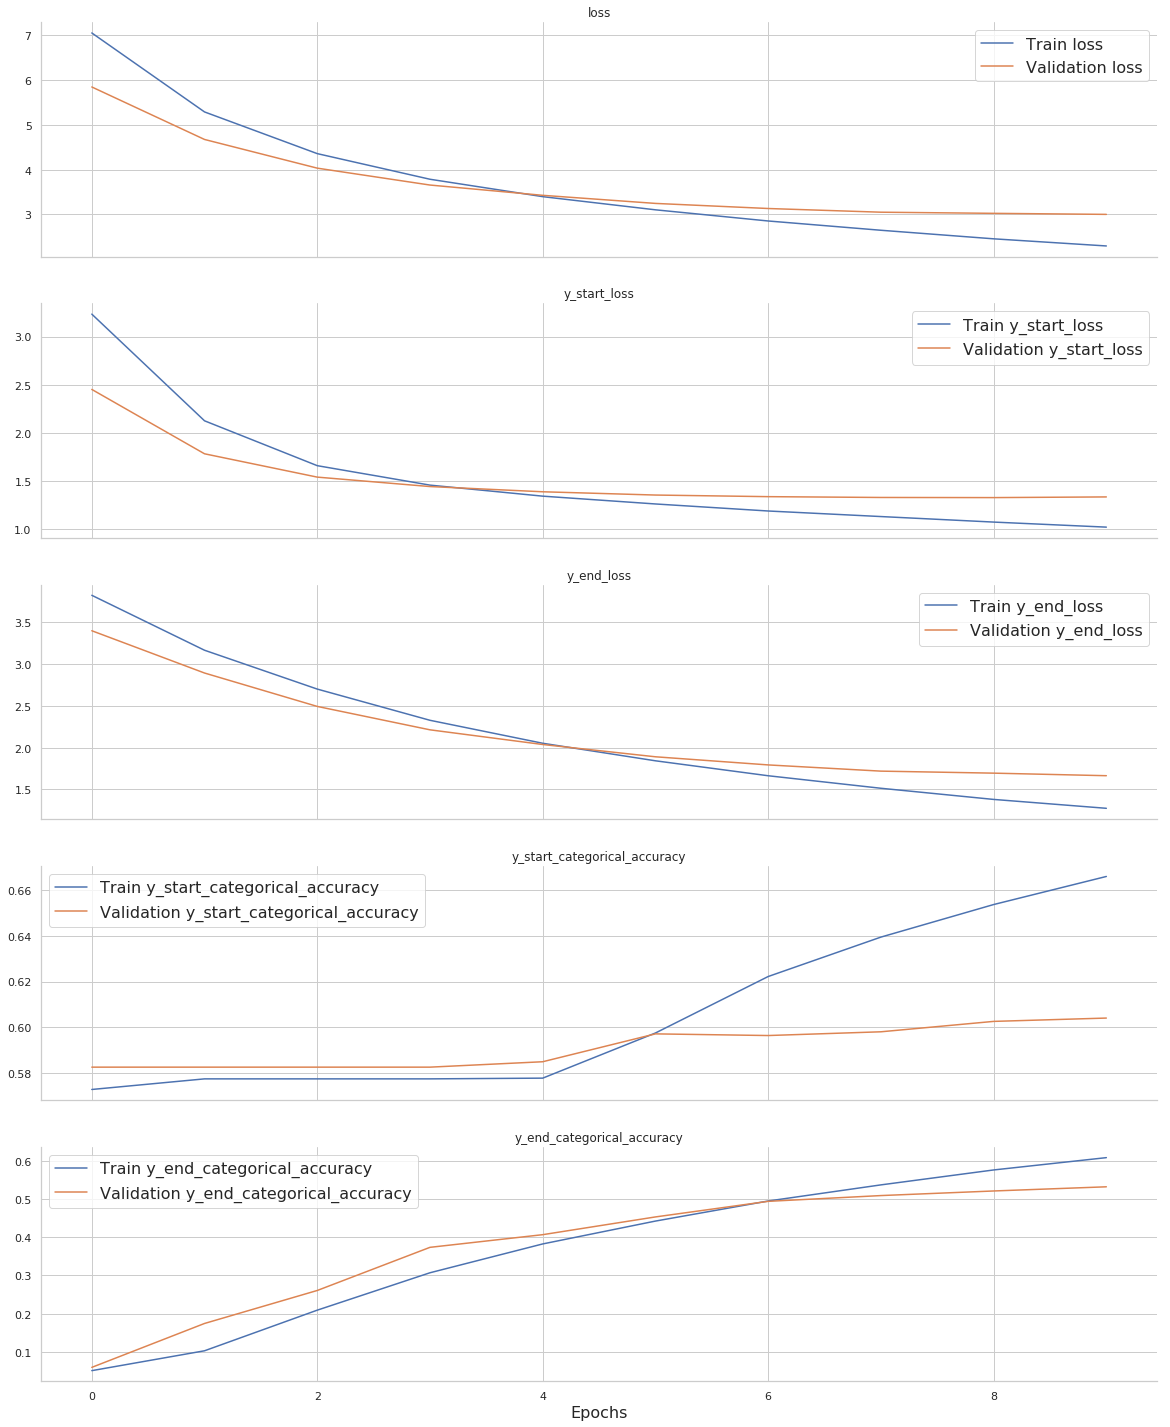

In [10]:
sns.set(style="whitegrid")
plot_metrics(history, metric_list=['loss', 'y_start_loss', 'y_end_loss', 'y_start_categorical_accuracy', 'y_end_categorical_accuracy'])

# Model evaluation

In [11]:
train_preds = model.predict(x_train)
valid_preds = model.predict(x_valid)

train['start'] = train_preds[0].argmax(axis=-1)
train['end'] = train_preds[1].argmax(axis=-1)
train['prediction'] = train.apply(lambda x: decode(x['start'], x['end'], x['text'], tokenizer), axis=1)
train["prediction"] = train["prediction"].apply(lambda x: '.' if x.strip() == '' else x)

validation['start'] = valid_preds[0].argmax(axis=-1)
validation['end'] = valid_preds[1].argmax(axis=-1)
validation['prediction'] = validation.apply(lambda x: decode(x['start'], x['end'], x['text'], tokenizer), axis=1)
validation["prediction"] = validation["prediction"].apply(lambda x: '.' if x.strip() == '' else x)

evaluate_model(train, validation)

Train set Jaccard: 0.725
Validation set Jaccard: 0.616

Metric by sentiment

Sentiment == neutral
Train set Jaccard: 0.971
Validation set Jaccard: 0.966

Sentiment == positive
Train set Jaccard: 0.558
Validation set Jaccard: 0.377

Sentiment == negative
Train set Jaccard: 0.562
Validation set Jaccard: 0.362


# Visualize predictions

In [12]:
print('Train set')
display(train.head(10))

print('Validation set')
display(validation.head(10))

Train set


,textID,text,selected_text,sentiment,start,end,prediction,jaccard
2288,809b2b787d,Man with a kickin' top hat just left. Invited ...,Man with a kickin' to,positive,1,5,Man with a kickin,0.500000
19804,a25ea87900,well dnt really knw wot to do stay wit some 1 ...,well dnt really knw wot to do,negative,1,10,well dnt really knw wot to do,1.000000
12673,4144306c53,id be happy thats its friday if i didnt have t...,id be happy thats its friday if i didnt have t...,neutral,1,16,id be happy thats its friday if i didnt have t...,1.000000
2528,65711a3401,_chick Hello,_chick Hello,neutral,1,3,_chick Hello,1.000000
4046,69a4e7a6f5,"Ouch, I'm sorry then",sorry,negative,5,6,m sorry,0.500000
22096,011809f662,and no I didn't burn the eggs. We had a blas...,We had a blast,positive,20,26,all weekend. We had an awesome,0.250000
18600,7c07e5d4a3,DUDE. You're a hax0r!!!1! You should put Fi...,DUDE. You're a hax0r!!!1! You should put Fin...,neutral,1,30,DUDE. You're a hax0r!!!1! You should put Final...,1.000000
3866,89cdcbfb73,everyone's abandoning the office... I still ha...,everyone's abandoning the office... I still ha...,neutral,1,16,everyone's abandoning the office... I still ha...,1.000000
19535,e4db70af7f,_berra happy bday stevie bee...and if u want f...,y babies r the best!,positive,24,32,tweety may babies r the best!,0.571429
23788,67cc48a34f,"Boom, and if you will, boom! Saw the movie la...",enjoyed,positive,17,18,enjoyed it,0.500000


Validation set


,textID,text,selected_text,sentiment,start,end,prediction,jaccard
7321,37dc843ad5,YAY!! I was supposed to be there next weeken...,YAY!!,positive,1,1,YAY,0.000000
3075,751762b290,Doing okay. How are you doing?,Doing okay.,neutral,1,8,Doing okay. How are you doing?,0.333333
25268,ebeea1f86c,Am hating my life at the moment. There's only ...,hating,negative,1,2,Am hating,0.500000
18745,2012705b97,And it's only downhill from now until Labor ...,y downhill,negative,1,12,And it's only downhill from now until Labor Day!,0.100000
21804,3d465939ee,okay for your Mom and My Mom too!,okay for your Mom and My Mom too!,neutral,1,9,okay for your Mom and My Mom too!,1.000000
19847,bd085c659b,G'night!,G'night,neutral,1,4,G'night!,0.000000
8456,254254dfec,thanks to the forever 21 curse that makes you ...,thanks to the forever 21 curse,negative,1,26,thanks to the forever 21 curse that makes you ...,0.300000
700,7dfebebd27,In the university with hungry!!,In the university with hungry!!,neutral,1,7,In the university with hungry!!,1.000000
12131,9ee143d387,going to program now haven't programmed for a...,haven't programmed,negative,1,12,going to program now haven't programmed for a ...,0.200000
2122,f4df0a8b35,Thinks that my friends lifes go around with wh...,not time for us girls,negative,17,21,they have not time for,0.428571
